# EXPERIMENTAL NOTEBOOK

# Modeling Energy Levels with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the ENSDF Dataset and builds a model to predict the level energy of several isotopes. To do this, we'll provide the model with a description of many expeirmentally measrued values and accepted values. This description includes attributes like: # of neutrons, # of protons, and Atomic Mass.

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.0.0


In [140]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [141]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [142]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2227024361721006132, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6614766059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3102803190146614565
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:42:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6618563871
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3481161525202996582
 physical_device_desc: "device: 1, name: GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"]

# Getting the Data: Cross Sections

In [143]:
print("Reading data into dataframe...")
df = pd.read_csv("./ENSDF/ensdf_v1.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Spin", "Parity", "Element_w_A", "Element"]
df[str_cols] = df[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Level_Number", "Protons", "Target_Neutrons", "Target_Mass_Number"]
df[int_cols] = df[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [144]:
print("Reading data into dataframe...")
df2 = pd.read_csv("./ENSDF/ensdf_v2.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Spin", "Parity", "Element_w_A"]
df2[str_cols] = df2[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df2.columns):
    if col not in str_cols:
        df2[col] = df2[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Level_Number", "Protons", "Target_Neutrons"]
df2[int_cols] = df2[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [153]:
basic_cols = ["Level_Number", "Level_Energy", "Protons", "Target_Neutrons", "Atomic_Mass_Micro"]
df = df[basic_cols]
df2 = df2[basic_cols]

In [154]:
# # Specify categorical variables calculating one-hot-encode features 
# # The useful categorical feature can also be Out, in this case we use OUT
# cat_cols = ["MT", "spin", "parity"]
# df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

In [155]:
from sklearn.metrics import mean_squared_error, r2_score

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
train_size = 0.8
test_size = 1 - 0.8
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Level_Energy"], axis=1), df["Level_Energy"], test_size=0.20)

In [158]:
from sklearn import preprocessing

In [159]:
# Specify columns to scale
to_scale = list(x_train.columns)
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])

In [160]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

In [161]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Level Energy (MeV)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [162]:
def predicting_nuclear_xs(protons, neutrons, clf, tf_dataset=False):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, N).
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True)
    to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns="Level_Energy")

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    
    if tf_dataset == True:
        infer_dataset = tf.data.Dataset.from_tensor_slices(
            (to_infer.values, to_plot["Level_Energy"].values)).batch(len(to_infer))
        y_hat  = clf.predict(infer_dataset)
    # Making Prediction with given model
    else:
        y_hat  = clf.predict(to_infer.values)
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Level Energy (MeV)')
    plt.xlabel('Level Number')
    plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
    all_y = np.concatenate((to_plot["Level_Energy"], y_hat[0]))
    minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
    maximum_y = all_y.max() + all_y.max() * 0.05
    plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    # Measuring metrics on predictions.
    print("XS Tree vs EXFOR:")
    print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
    print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))
    
    plt.figure(figsize=(16,10))     
    count, division = np.histogram(to_plot.Level_Energy, bins=binning)
    histogram = pd.DataFrame(y_hat, columns=["Level_Energy"])
    histogram.Level_Energy.hist(bins=division)
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.xlabel('Energy (MeV)')

In [163]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [164]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

NameError: name 'STEPS_PER_EPOCH' is not defined

In [232]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200), # val_loss
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE=None, 
                    np_dataset=False, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()
    if np_dataset == True:
        history = model.fit(
            train_dataset, test_dataset, batch_size = BATCH_SIZE,
            steps_per_epoch = (len(train_dataset)*0.8)//BATCH_SIZE,
            epochs=max_epochs,
            validation_split=0.2,
            callbacks=get_callbacks(name),
            verbose=0)
    else:
        history = model.fit(
            train_dataset,
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs=max_epochs,
            validation_data=test_dataset,
            callbacks=get_callbacks(name),
            verbose=0)        
    return history

In [253]:
cpu_strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
single_gpu_strategy =  tf.distribute.OneDeviceStrategy(device="/GPU:0")
gpu_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(gpu_strategy.num_replicas_in_sync))

Number of devices: 2


In [254]:
N_VALIDATION = len(x_test)
N_TRAIN = len(x_train)
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 500
FEATURES = len(x_train.columns)

In [255]:
def tf_dataset_gen(x, y, xt, yt, BUFFER_SIZE, BATCH_SIZE, gpu=False, multiplier=0, cache=False):
    if gpu == True:
        BATCH_SIZE = BATCH_SIZE * multiplier
        print("GPU: ON")
    train_dataset = tf.data.Dataset.from_tensor_slices((x.values, y.values)).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((xt.values, yt.values)).batch(BATCH_SIZE)
    if cache == True: # Ensures loader doesnt re-read data at each epoch.
        train_dataset = train_dataset.cache()
        test_dataset = test_dataset.cache()
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    print("BATCH SIZE: ", BATCH_SIZE)
    print("STEPS PER EPOCH: ", STEPS_PER_EPOCH)
    return train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE

In [256]:
train_dataset, test_dataset, STEPS_PER_EPOCH_CPU, BATCH_SIZE_CPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, BATCH_SIZE)

BATCH SIZE:  500
STEPS PER EPOCH:  116


In [257]:
train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, BATCH_SIZE_GPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, 5000, gpu=True, multiplier=2)

GPU: ON
BATCH SIZE:  10000
STEPS PER EPOCH:  5


# Training Models

In [258]:
size_histories = {}
size_histories_gpu = {}

In [259]:
%%time
with cpu_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(1)])
    size_histories['Tiny_CPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_CPU', train_dataset, 
                                                 test_dataset, STEPS_PER_EPOCH_CPU, max_epochs=300)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:28.3409,  mae:4.1921,  mse:28.3409,  val_loss:23.4953,  val_mae:3.8108,  val_mse:23.3019,  
....................................................................................................
Epoch: 100, loss:4.6572,  mae:1.3264,  mse:4.6572,  val_loss:4.5737,  val_mae:1.3112,  val_mse:4.5756,  
....................................................................................................
Epoch: 200, loss:4.1260,  mae:1.2623,  mse:4.1260,  val_loss:4.0757,  val_mae:1.2477,  val_mse:4.0853,  

In [260]:
%%time
with cpu_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(1)])
    size_histories['Tiny_CPU_np'] = compile_and_fit(tiny_model, 'sizes/Tiny_CPU_np', x_train.values, y_train.values,
                                                 STEPS_PER_EPOCH_CPU, BATCH_SIZE_CPU, np_dataset=True, max_epochs=300)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:28.7740,  mae:4.0650,  mse:28.7740,  val_loss:23.9832,  val_mae:3.7589,  val_mse:23.9832,  
....................................................................................................
Epoch: 100, loss:4.6779,  mae:1.3393,  mse:4.6779,  val_loss:4.8675,  val_mae:1.3608,  val_mse:4.8675,  
....................................................................................................
Epoch: 200, loss:4.2644,  mae:1.2849,  mse:4.2644,  val_loss:4.4770,  val_mae:1.3063,  val_mse:4.4770,  

In [261]:
%%time
with single_gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU1'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU1', 
                                                 train_dataset, test_dataset, STEPS_PER_EPOCH_CPU, max_epochs=300)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:33.6472,  mae:4.1524,  mse:33.6472,  val_loss:27.3710,  val_mae:3.8093,  val_mse:27.0769,  
....................................................................................................
Epoch: 100, loss:4.3974,  mae:1.3041,  mse:4.3974,  val_loss:4.3514,  val_mae:1.2766,  val_mse:4.3637,  
....................................................................................................
Epoch: 200, loss:4.0767,  mae:1.2652,  mse:4.0767,  val_loss:3.9941,  val_mae:1.2533,  val_mse:4.0114,  

In [262]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:35.5261,  mae:4.3551,  mse:35.5261,  val_loss:26.2462,  val_mae:4.3207,  val_mse:34.9804,  
....................................................................................................
Epoch: 100, loss:5.7262,  mae:1.4684,  mse:5.7262,  val_loss:4.3273,  val_mae:1.4666,  val_mse:5.7666,  
....................................................................................................
Epoch: 200, loss:5.5109,  mae:1.4720,  mse:5.5109,  val_loss:4.1758,  val_mae:1.4698,  val_mse:5.5647,  

Text(0, 0.5, 'MSE [XS^2]')

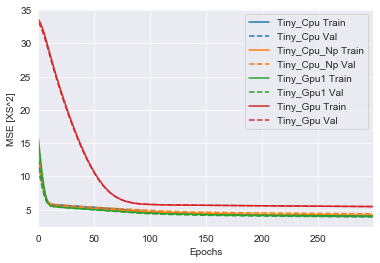

In [263]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=5)
plotter.plot(size_histories)
plt.ylim()
plt.ylabel('MSE [XS^2]')

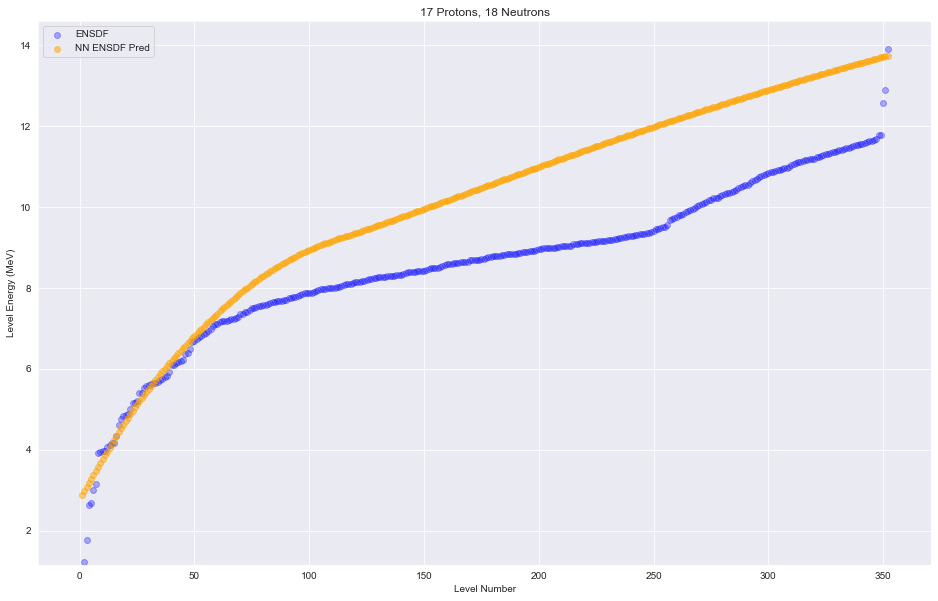

XS Tree vs EXFOR:
The MSE is:  2.8960189622097214
The R2-Score is:  0.2946787968192268


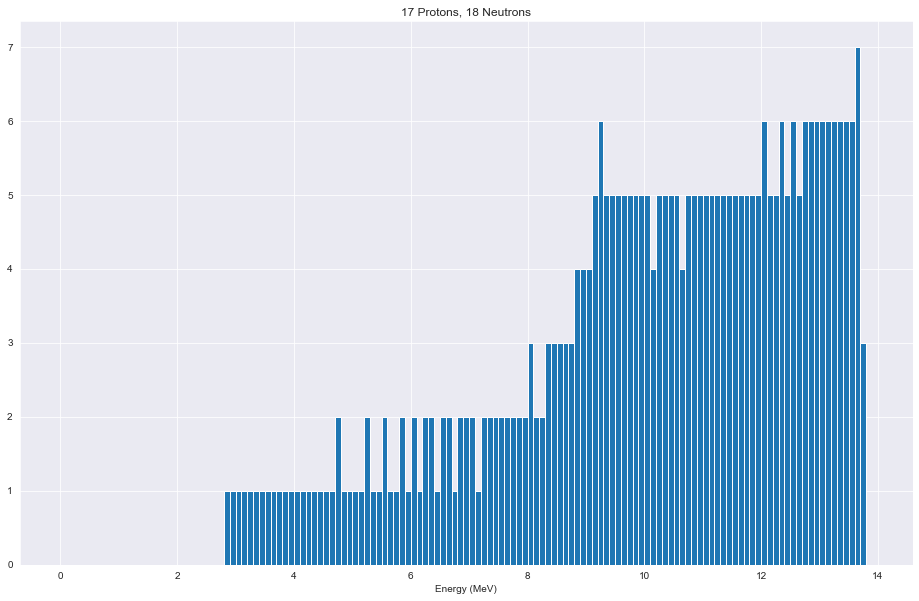

In [264]:
predicting_nuclear_xs(17, 35-17, size_histories['Tiny_CPU'].model, tf_dataset=True)

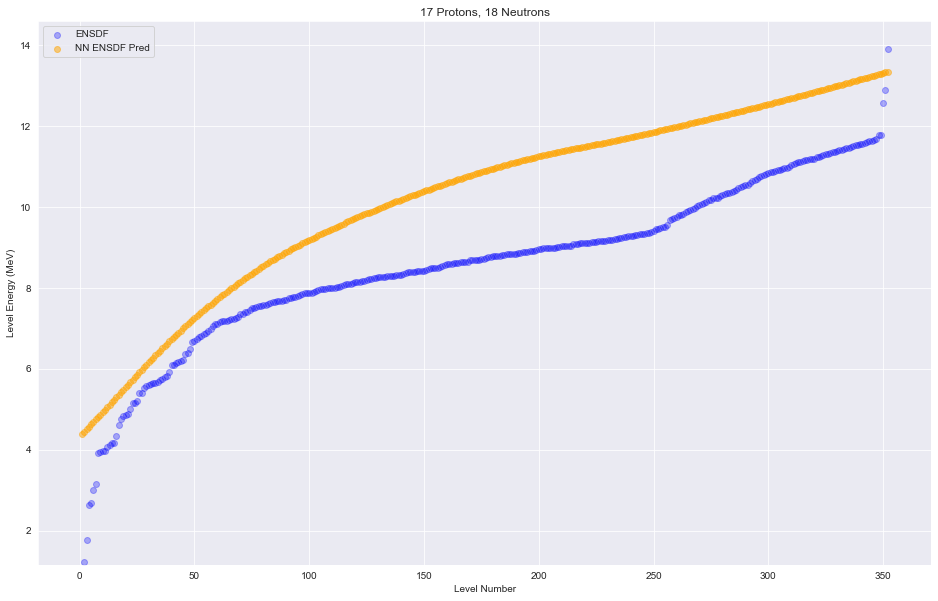

XS Tree vs EXFOR:
The MSE is:  3.163713332281202
The R2-Score is:  0.2294822226091361


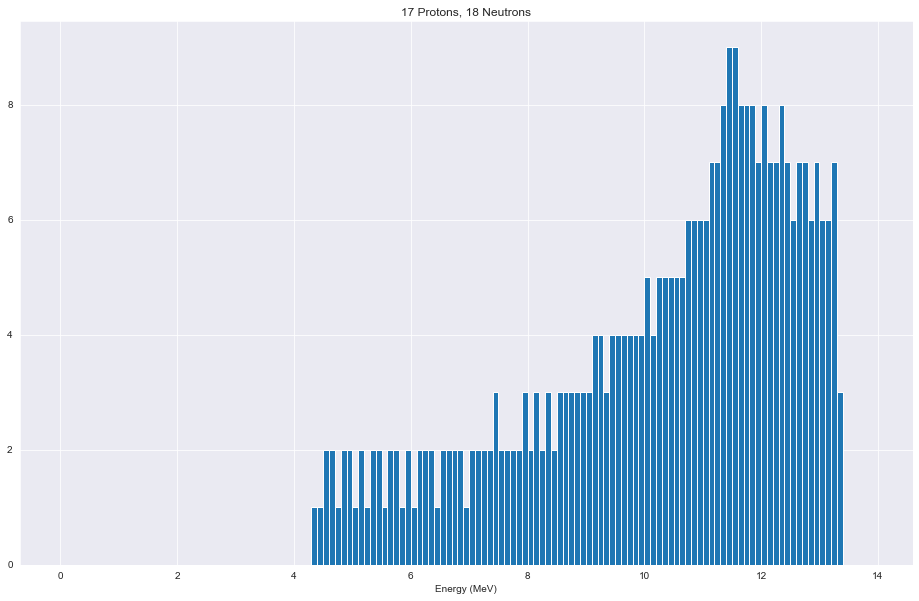

In [268]:
# FOR THIS TO WORK WE NEED TO MODIFY FUNCTION TO HANDLE DATSETS
predicting_nuclear_xs(17, 35-17, size_histories['Tiny_CPU_np'].model, tf_dataset=True)

In [269]:
%%time
with gpu_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['Medium_GPU'] = compile_and_fit(medium_model, 'sizes/Medium_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_70 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:29.8993,  mae:4.2509,  mse:29.8993,  val_loss:19.9654,  val_mae:4.1391,  val_mse:26.6073,  
....................................................................................................
Epoch: 100, loss:4.7223,  mae:1.3544,  m

In [275]:
%%time
with gpu_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['Large_GPU'] = compile_and_fit(large_model, 'sizes/Large_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_83 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_84 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_85 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:24.0106,  mae:3.9685,  mse:24.0106,  val_loss:10.7072,  val_mae:3.0169,  val_mse:14.2682,  
.....

In [73]:
# from bokeh.plotting import figure, output_file, show
# output_file("lines.html")

In [87]:
# # create a new plot with a title and axis labels
# p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# # add a line renderer with legend and line thickness
# p.line(np.linspace(0, 99, 100), pd.DataFrame(size_histories["large"].history)["mse"], legend="Temp.", line_width=2)

# # show the results
# show(p)

In [308]:
plt.figure(figsize=(15,10))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

KeyError: None

<Figure size 1080x720 with 0 Axes>

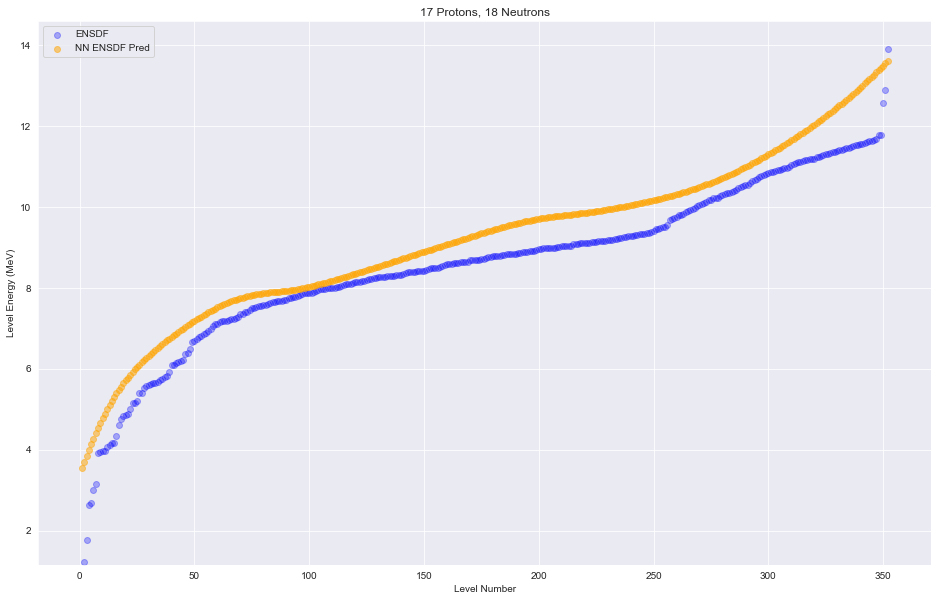

XS Tree vs EXFOR:
The MSE is:  0.5292719005663155
The R2-Score is:  0.8710965989558412


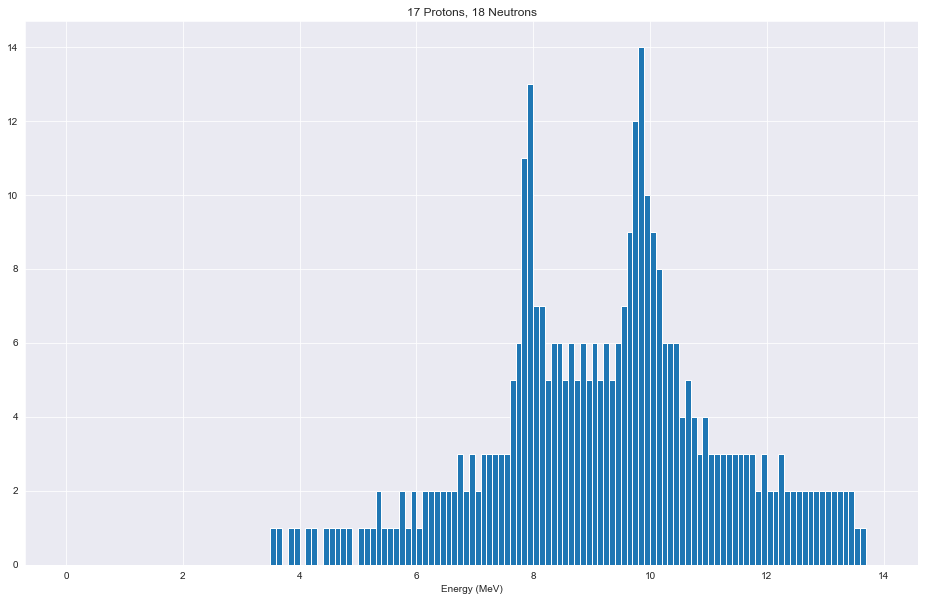

In [278]:
predicting_nuclear_xs(17, 35-17, size_histories['Large_GPU'].model, tf_dataset=True)

In [279]:
regularizer_histories = {}
regularizer_histories['Tiny_CPU'] = size_histories['Tiny_CPU']

In [281]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_98 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_99 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_100 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:25.5913,  mae:3.9837,  mse:24.0445,  val_loss:12.4964,  val_mae:3.0508,  val_mse:14.5898,  
.....

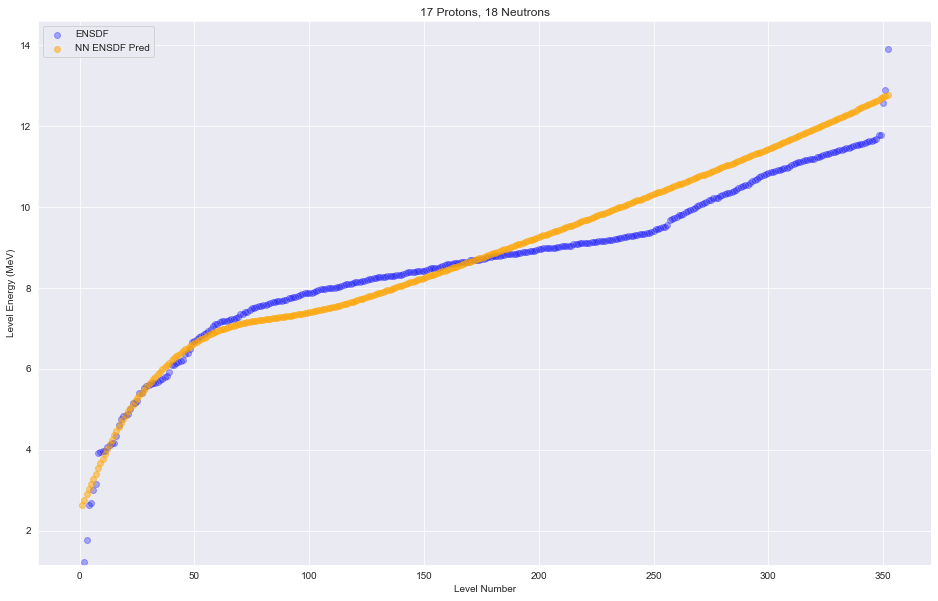

XS Tree vs EXFOR:
The MSE is:  0.29727286011451004
The R2-Score is:  0.9275996275905005


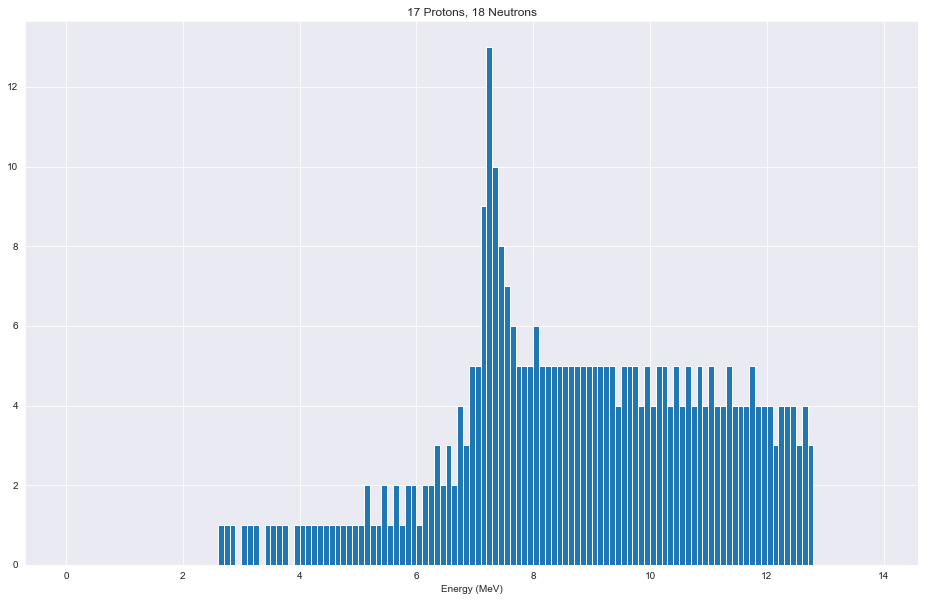

In [295]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['l2'].model, tf_dataset=True)

In [138]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2_2000'] = compile_and_fit(l2_model, 'regularizers/l2_2000', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=10000)

NameError: name 'gpu_strategy' is not defined

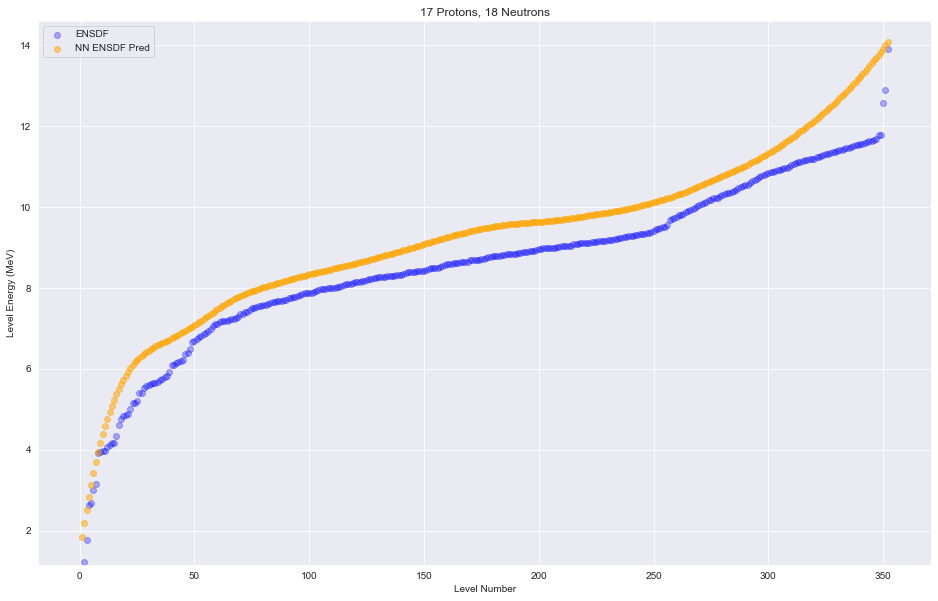

XS Tree vs EXFOR:
The MSE is:  0.5596633144630709
The R2-Score is:  0.8636948143350428


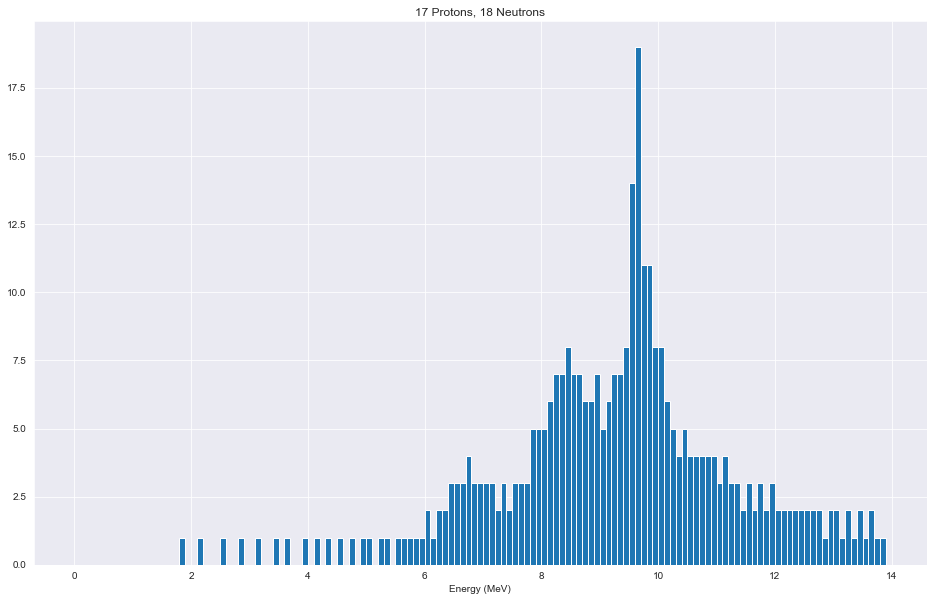

In [297]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['l2_2000'].model, tf_dataset=True)

In [283]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 512)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)             

In [303]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=300)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 512)               2560      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)             

In [307]:
plt.figure(figsize=(15,10))
plotter.plot(regularizer_histories)

KeyError: None

<Figure size 1080x720 with 0 Axes>

In [290]:
hist = pd.DataFrame(regularizer_histories['l2'].history)
hist['epoch'] = regularizer_histories['l2'].epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,3.423054,1.001607,2.655203,2.700178,0.975487,2.573845,295
296,3.360027,1.001824,2.592768,2.696059,0.989105,2.569116,296
297,3.418146,1.010282,2.651459,2.675017,0.977214,2.541878,297
298,3.681805,1.067090,2.915823,2.717230,0.984647,2.599586,298
299,3.674703,1.070685,2.909691,2.951144,1.073622,2.913288,299


In [75]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./Checkpoints/L2/L2/"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [76]:
regularizer_histories['l2'].model.save_weights(checkpoint_dir)

In [216]:
activation_fn = "elu"
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=[len(x_train.keys())]),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

l2_model_exp = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 512)               67584     
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_121 (Dense)            (None, 1000)              513000    
_________________________________________________________________
dense_122 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_123 (Dense)            (None, 512)               512512    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 512)             

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


.........................................
Epoch: 100, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
.............

In [223]:
plotter.plot(l2_model_exp)

AttributeError: 'History' object has no attribute 'items'